In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
import pyper
R = pyper.R(use_pandas='True')

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 5.5, 3.5

# Create Data

In [3]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

K = 3 # number of coefficients, including the constant

In [4]:
X = np.array(([ [1,  float(np.random.normal(0,2)),float(np.random.normal(0,0.5))] for i in range(1500)  ]))
print(X.shape)

(1500, 3)


In [5]:
beta = np.array([0.5, 1.5, 2.5])
print(beta.shape)
print(beta)

(3,)
[ 0.5  1.5  2.5]


In [6]:
Xbeta = np.dot(X, beta) # + np.random.logistic(scale=0.15, size=X.shape[0]) # do not forget to add an error term
pi = sigmoid(Xbeta)
print(pi.shape)
print(pi[:15])

(1500,)
[  2.13799767e-02   2.54343155e-01   9.91391731e-01   6.01207715e-05
   9.48227916e-01   9.80358735e-01   9.99328430e-01   9.51665006e-01
   2.50712603e-01   8.97558371e-01   2.62692504e-01   7.83225874e-01
   7.61404721e-02   3.54418758e-02   9.18721957e-01]


In [7]:
Y = np.array([np.random.binomial(1, p=prob) for prob in pi])
print(Y.shape)
print(Y[:5])

(1500,)
[0 0 1 0 1]


In [8]:
# Package result
clf.fit(X, Y)
clf.coef_[0]

array([ 0.27558849,  1.46320943,  2.4936283 ])

In [9]:
# Check with R
df = pd.concat([pd.DataFrame(Y), pd.DataFrame(X)], axis=1)
df.columns = ['Y', 'X1', 'X2', 'X3']
R.assign("data",  df)
print(R('summary(glm(Y ~ X2 + X3, data = data, family = "binomial"))'))

try({summary(glm(Y ~ X2 + X3, data = data, family = "binomial"))})

Call:
glm(formula = Y ~ X2 + X3, family = "binomial", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3960  -0.4329   0.1087   0.4773   2.7129  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.56022    0.08336   6.721 1.81e-11 ***
X2           1.49185    0.07858  18.985  < 2e-16 ***
X3           2.60432    0.20140  12.931  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2034.15  on 1499  degrees of freedom
Residual deviance:  972.66  on 1497  degrees of freedom
AIC: 978.66

Number of Fisher Scoring iterations: 6




# Check Likelihood Function

Move only one parameter and check likelihood function.

In [10]:
def loglikelihood(beta, X):
    N = X.shape[0]
    return (logsigmoid(np.dot(X, beta)) * Y).sum() + (logsigmoid(-np.dot(X, beta)) * (1 - Y)).sum() 

def logsigmoid(x):
    return - np.log(1 + np.exp(-x))

x      0.560000
y   -486.556244
Name: 56, dtype: float64
56


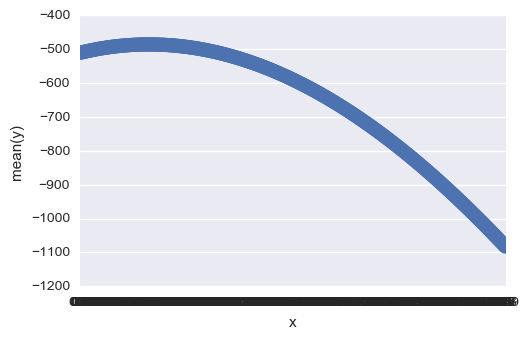

In [11]:
valuerange = np.arange(0, 3.5, 0.01)

loglikelihood_res = np.array([ loglikelihood( np.array([value, 1.5, 2.5]) , X) for value in valuerange])
#loglikelihood_res = np.array([ loglikelihood( np.array([1, value, 2.5]) , X) for value in valuerange])
#loglikelihood_res = np.array([ loglikelihood( np.array([1, 1.5, value]) , X) for value in valuerange])
#loglikelihood_res = np.array([ loglikelihood( np.array([value]) , X) for value in valuerange])
# True np.array([0.5, 1.5, 2.5])    

data = pd.DataFrame({"x":valuerange, "y": loglikelihood_res})
sns.pointplot(x="x", y="y", data=data)
print(data.ix[data["y"].idxmax(), :])
print(data["y"].idxmax())

# Metropolis-Hastings

In [12]:
def proposal(value):
    return value + npr.normal(0,0.05)

def logsigmoid(x):
    return - np.log(1 + np.exp(-x))

def loglikelihood(beta, X):
    N = X.shape[0]
    lik =  (logsigmoid(np.dot(X, beta)) * Y).sum() + (logsigmoid(-np.dot(X, beta)) * (1 - Y)).sum()  + \
                ( -0.5 * np.log(2 * np.pi) - 0.5 * np.log(100) - (0.5/100) * np.power(beta, 2)).sum() # prior N(0,10)
    
    return lik

In [13]:
num_sampling = 2000
chain = np.zeros((num_sampling, K))
accept = 0

for i in range(1, num_sampling):
    param_current = chain[i-1][:]
    param_new = np.zeros(K)
    
    for k in range(K):
        param_proposal = param_current.copy()
        new_value = proposal(param_current[k])
        param_proposal[k] = new_value
        
        diflikelihood = loglikelihood(param_proposal, X) - loglikelihood(param_current, X)
        r = min(0, diflikelihood) # np.log(1) = 0
        u = np.log(npr.uniform(0,1))
        
        if u < r:
            accept  += 1
            param_new[k] = new_value.copy()
        else:
            param_new[k] = param_current[k].copy()
        
    chain[i, :] = param_new.copy()
    
show_num = 500
accept / (num_sampling*K)

0.8248333333333333

0.578179069214


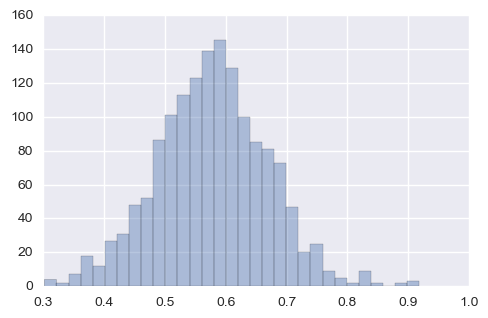

In [14]:
# 0.5
sns.distplot(chain[show_num: , 0], hist=True, kde=False)
#plt.plot([10, 10], [0, 1400], linewidth=2, color='red')
print(np.median(chain[show_num: , 0]))

1.4900932374


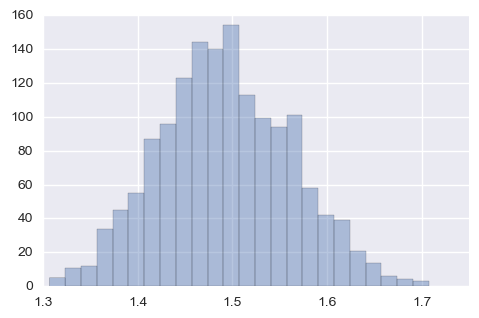

In [15]:
# 1.5
sns.distplot(chain[show_num: , 1], hist=True, kde=False)
#plt.plot([10, 10], [0, 1400], linewidth=2, color='red')
print(np.median(chain[show_num: , 1]))

2.60461334235


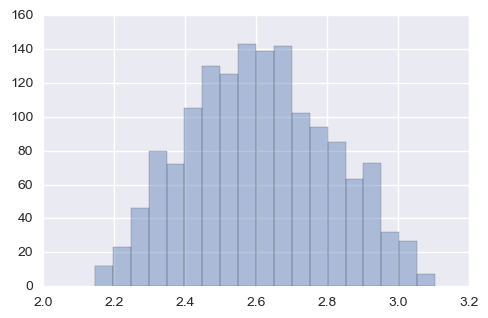

In [16]:
# 2.5
sns.distplot(chain[show_num: , 2], hist=True, kde=False)
#plt.plot([10, 10], [0, 1400], linewidth=2, color='red')
print(np.median(chain[show_num: , 2]))

# PRML1

In [17]:
def BayesianLogisticRegression(X, t, iter_max, alpha):
    # From: http://qiita.com/Gordian_knot/items/0c3315dca6f2fa83b544
    def _sigmoid(a):
        return np.divide(1, 1 + np.exp(-a))
    
    def predict_proba(X, w):
        return _sigmoid(X.dot(w))
 
    w = np.zeros(np.size(X, 1))
    for i in range(iter_max):
        w = np.copy(w)
        y = predict_proba(X, w)
        grad = X.T.dot(y - t) + alpha * w
        hessian = (X.T.dot(np.diag(y * (1 - y))).dot(X)
               + alpha * np.identity(len(w)))
        try:
            w_new = w - np.linalg.inv(hessian).dot(grad)
        except np.linalg.LinAlgError:
            break
        if np.allclose(w_new, w):
            break
        if i == iter_max - 1:
            print ("weight parameter w may not have converged")
            
        w = w_new

    w_var = np.linalg.inv(hessian)

    return w

In [18]:
BayesianLogisticRegression(X, Y,iter_max=2000, alpha=0.1)

array([ 0.55906642,  1.48876696,  2.5925218 ])